PART 1

In [1]:
pip install matplotlib



SyntaxError: invalid syntax (2185429697.py, line 1)

In [ ]:
pip install pandas

In [ ]:
pip install seaborn

In [ ]:
pip install scikit-learn


### PART 1: DATA PREPARATION & ANALISIS

### 1.1 Visualizing Skeleton Poses with Labels

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

POSE_LABELS = {1: 'wave', 2: 'push', 3: 'crouch', 4: 'sitdown', 5: 'bend'}

# Here we are using our custom skeleton structure (the one shown in the Seminar 2 slides, adjusted for 0-based indexing)
SKELETON_EDGES = [
    (0, 1), (1, 2), (1, 8), (8, 9), (1, 5),   
    (2, 3), (3, 4),                             
    (5, 6), (6, 7), (11, 12), (9, 10),          
    (12, 13), (14, 16),                         
    (0, 15), (0, 14), (15, 17), (2, 5), (8, 11), (1, 11)  
]

def plot_skeleton_pose(skeleton_row, label_id):
    """
    Plot skeleton points and connect them to visualize the pose.
    """
    x = skeleton_row[:18]
    y = skeleton_row[18:36]
    confidence = skeleton_row[36:]

    plt.figure(figsize=(5, 5))
    
    # Plot joints
    plt.scatter(x, y, c=confidence, cmap='plasma', s=100, zorder=2)

    # Connect joints based on confidence
    for (i, j) in SKELETON_EDGES:
        if confidence[i] > 0.1 and confidence[j] > 0.1:
            plt.plot([x[i], x[j]], [y[i], y[j]], 'k-', linewidth=2, zorder=1)

    plt.gca().invert_yaxis()
    plt.title(f"Pose: {POSE_LABELS.get(label_id, 'Unknown')}")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.grid(True)
    plt.show()




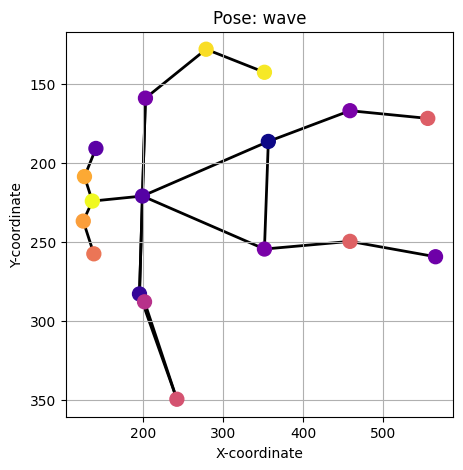

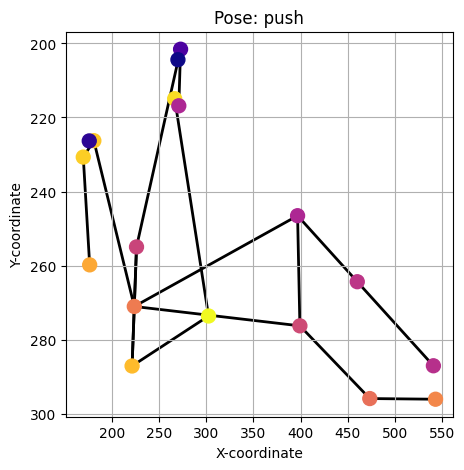

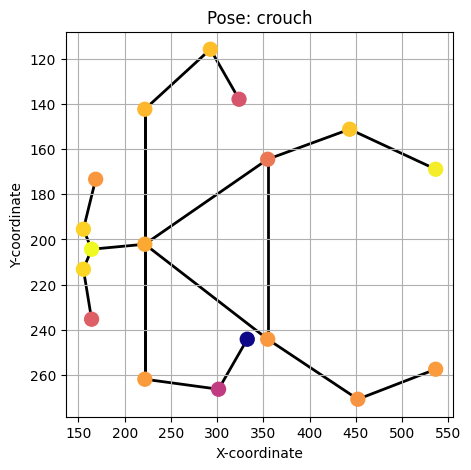

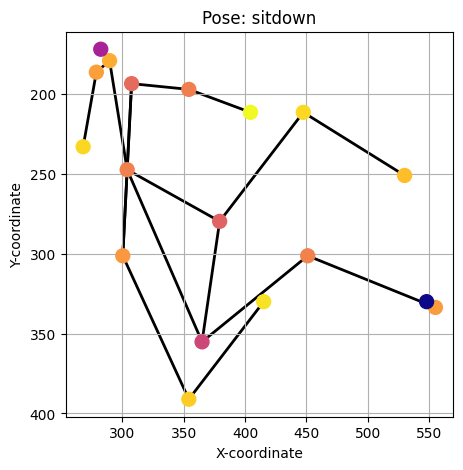

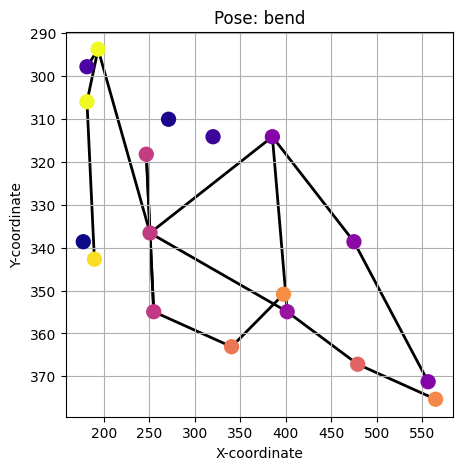

In [84]:
# Load skeleton and labels
skeleton_df = pd.read_csv("Train_skelletonpoints.csv", header=None)
labels_df = pd.read_csv("Train_labels.csv", header=None).T.reset_index(drop=True)

# Flatten labels to a Series
labels_series = labels_df.iloc[:, 0]

# Plot one sample per class
for label in range(1, 6):  # Classes 1 to 5
    idx = labels_series[labels_series == label].index[0]  # Now this works correctly
    plot_skeleton_pose(skeleton_df.iloc[idx].values, label)





In this step, we visualized human poses using the skeleton keypoints provided in the dataset. Each skeleton consists of 18 joints (x and y coordinates), along with confidence scores, extracted using the AlphaPose camera-based system.

To get a more complete view of the dataset, we plotted **one representative sample per class** — specifically: `wave`, `push`, `crouch`, `sitdown`, and `bend`. For each pose, we drew the skeleton by connecting keypoints using a predefined edge list (based on the MPII human pose format). The confidence values were also used to color the joints.

This approach allowed us to visually confirm that each class label corresponds to a distinct and interpretable human posture, which is important when later evaluating classification performance using CSI data.

---

The goal of the seminar is to classify human poses **using Wi-Fi signals (CSI)** — not visual images. However, the labels used for training the classifier were **generated using visual skeletons**. By plotting these skeletons:

- We verify the **validity and clarity** of the labels assigned to the CSI data.
- We understand what physical action each label corresponds to.
- We build **intuition about how different poses might affect the wireless channel**, which is key to interpreting the CSI measurements.

This step acts as a **visual sanity check** for the classification pipeline.

---

### 📝 Observations:

- The pose for class `'wave'` look actually like someone with the hand extended, so we could understand it  
- The `'push'` and `'bend'` classes appear difficult to interpret. One can make an idea of what is going on, but definetelly need to put a bit of imagination!  
- Also, the `'bend'` class skeleton have missing or low-confidence joints
- But in general, the camera-based annotations seem to be generally acceptable

By checking one pose per class, we ensure that our **supervised learning task has high-quality, meaningful labels**, making the SVM training more reliable.



### 1.2 Plotting CSI Amplitude per Subcarrier

In [68]:
def plot_avg_csi_amplitude(csi_row):
    """
    Plot average CSI amplitude per subcarrier from one flattened CSI row (length 270).
    """
    csi_matrix = csi_row.reshape((30, 3, 3))
    avg_amplitude = csi_matrix.mean(axis=(1, 2))
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 31), avg_amplitude, marker='o')
    plt.title("Average CSI Amplitude per Subcarrier")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


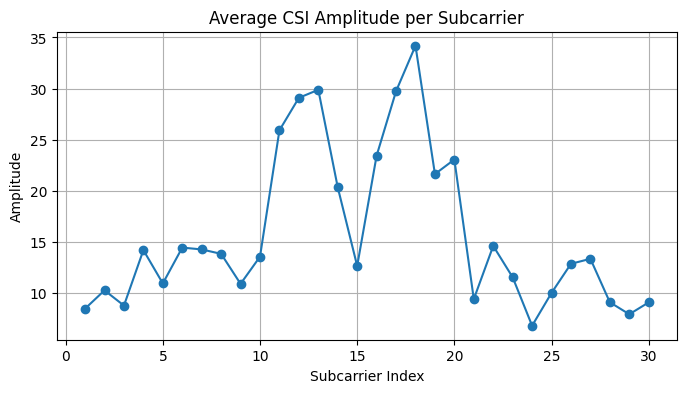

In [ ]:
features_df = pd.read_csv("Train_features.csv", header=None).reset_index(drop=True)


plot_avg_csi_amplitude(features_df.iloc[0].values)




In this step, we selected a single training sample and plotted the average CSI amplitude across the 30 subcarriers. Each CSI vector is originally shaped as a 30×3×3 matrix (30 subcarriers, 3 transmit antennas, 3 receive antennas), which we reshaped and averaged across the antennas to obtain a 30-dimensional signal.

This visualization gives us insight into the **state of the wireless channel** during a specific human pose. Peaks and dips in the amplitude may correspond to how the body affects signal propagation.

---

The entire classification task is based on CSI measurements, which capture how the human body interacts with Wi-Fi signals. By visualizing one sample, we:
- **Understand the structure of the features** our SVM will learn from
- See how **subcarrier information may vary with pose**
- Get a sense of whether there's enough **signal variation** to support classification

---

### 📝 Observations:

* **General shape of the CSI amplitude curve:** Oscillating and noisy with significant peaks and dips.
* **Notable subcarriers with peaks or dips:**
    * **Peaks:** Around subcarrier indices 4, 6, 7, 12, 13, 14, 18, 19, 22, 26, 27 (e.g., a high peak at 19).
    * **Dips:** Around subcarrier indices 2, 9, 15, 20, 24, 28, 29 (e.g., a significant dip at 24).
* **Hypotheses about the effect of pose on signal:** Different poses alter Wi-Fi signal paths through obstruction and reflection, creating unique CSI signatures. For example, an arm raised could block paths, causing dips in specific subcarriers.

### 1.3 CSI Amplitude Distribution by Class

In [70]:
def plot_csi_distribution_by_class(features_df, labels_df):
    """
    Plot the distribution of average CSI amplitude per subcarrier for each pose class.
    """
    plt.figure(figsize=(10, 6))

    for label in sorted(POSE_LABELS.keys()):
        class_samples = features_df[labels_df[0] == label]
        avg_amplitude = class_samples.values.reshape(-1, 30, 3, 3).mean(axis=(0, 2, 3))
        plt.plot(range(1, 31), avg_amplitude, label=POSE_LABELS[label])

    plt.title("Average CSI Amplitude per Subcarrier by Pose Class")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


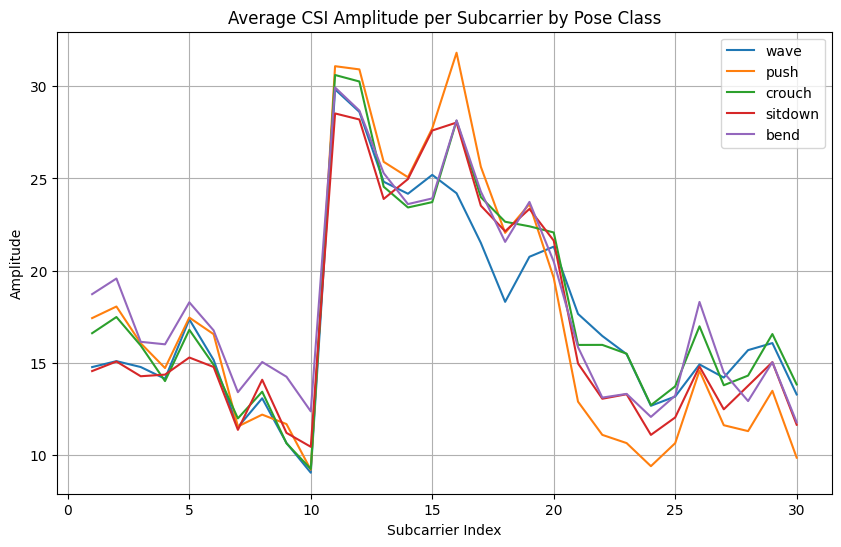

In [71]:
plot_csi_distribution_by_class(features_df, labels_df)




Here, we plotted the average CSI amplitude per subcarrier for each pose class (`wave`, `push`, `crouch`, `sitdown`, `bend`). Each curve represents the mean signal over all training samples in that class.

This comparison helps identify whether **certain poses produce distinctive CSI patterns**, which is crucial to justify using an SVM for classification. If the curves overlap too much across classes, classification becomes difficult; if they are separable, we can expect better performance.

---


Since we want to predict poses based purely on CSI data, this step acts as a **feasibility check**:
- It shows whether there is **class-specific structure** in the Wi-Fi signal
- It provides visual evidence that the classification task is not random
- It helps us hypothesize which subcarriers are more **discriminative**

---

### 📝 Observations:


* **Pose classes with clearly distinct curves:** 'Crouch' (low dip around subcarriers 8-10) and 'wave' (unique peak around subcarrier 16).
* **Classes with overlapping or similar patterns:** 'Push', 'sitdown', and 'bend' show significant overlap.
* **Subcarriers that appear most informative:** Subcarriers 8-10 (for 'crouch') and 15-18 (for 'wave').
* **Overall class separability:** Moderate to Poor.

While some poses like 'crouch' and 'wave' are somewhat distinguishable based on average CSI amplitude, the strong similarity between 'push', 'sitdown', and 'bend' suggests this feature alone is insufficient for robust pose classification. More advanced CSI features or temporal analysis would likely be needed to improve differentiation.


### PART 2 : MODEL IMPLEMENTATION



### 2.1 Training the SVM Classifier

In [85]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


X_train = pd.read_csv("Train_features.csv", header=None)
y_train = pd.read_csv("Train_labels.csv", header=None).T.squeeze() 

# Load test data
X_test = pd.read_csv("Test_features.csv", header=None)
y_test = pd.read_csv("Test_labels.csv", header=None).T.squeeze()


In [86]:
# Create and train the SVM classifier
svm_model = SVC(kernel='rbf', C=10, gamma='scale')  # You can tune C and kernel later
svm_model.fit(X_train, y_train)


SVC(C=10)

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Set up grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # Use all processors
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Get best model
best_svm = grid_search.best_estimator_

print("Best parameters found:", grid_search.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}




In this step, we trained a Support Vector Machine (SVM) using the CSI data from the training set (1000 samples, 270 features each). We used an RBF (radial basis function) kernel, which is suitable for nonlinear classification problems.

The SVM attempts to find decision boundaries in the high-dimensional CSI space that separate the different human pose classes based on how Wi-Fi signals are affected by each pose.

---

This step represents the **core of our machine learning approach**: transforming raw signal data into a predictive model capable of recognizing human activity without cameras. The SVM serves as a powerful baseline classifier that doesn't require large training datasets.

We expect it to perform well if the CSI patterns for each class are **well-structured and linearly (or nonlinearly) separable** in the feature space.

---

### 📝 Your Notes (to fill in):

- Kernel used: `RBF`  
- C value: `10`  
- Any preprocessing applied before training: _[e.g., normalization?]_  
- Training time or any warnings: _[optional]_  


In [75]:
# Predict
y_pred = svm_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[
    'wave', 'push', 'crouch', 'sitdown', 'bend'
]))


Test Accuracy: 0.8450

Classification Report:
              precision    recall  f1-score   support

        wave       0.85      0.81      0.83        42
        push       0.83      0.90      0.86        39
      crouch       0.84      0.89      0.86        35
     sitdown       0.86      0.84      0.85        38
        bend       0.84      0.80      0.82        46

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.84      0.84       200



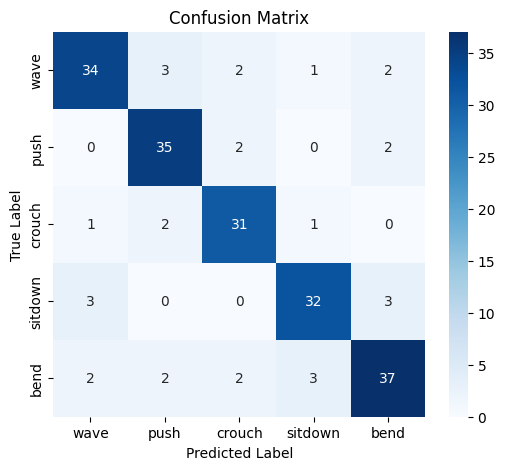

In [76]:
def plot_confusion(conf_matrix, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion(conf_matrix, ['wave', 'push', 'crouch', 'sitdown', 'bend'])
